In [ ]:
#นำเข้าไลบรารี่เตรียมตัวสำหรับการใช้งานนะครับน้องๆ
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import callbacks as cb
import os, json, math, librosa
import IPython.display as ipd
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split


C:\Users\lenovo\AiTg2\Data\genres_original\jazz\jazz.00031.wav


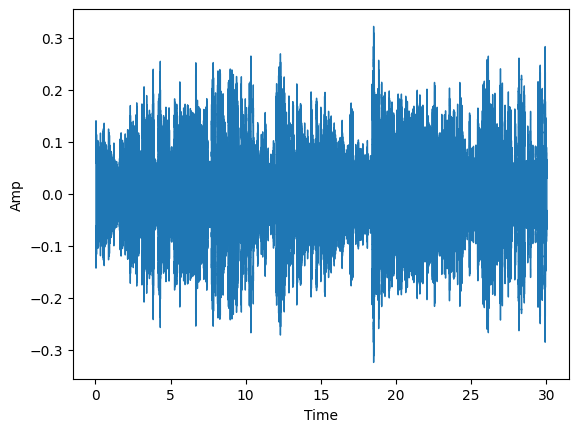

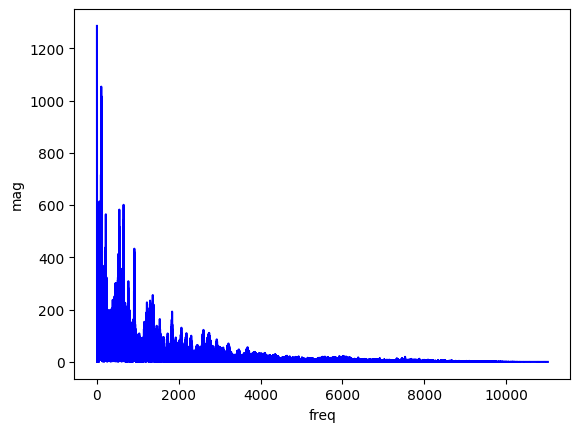

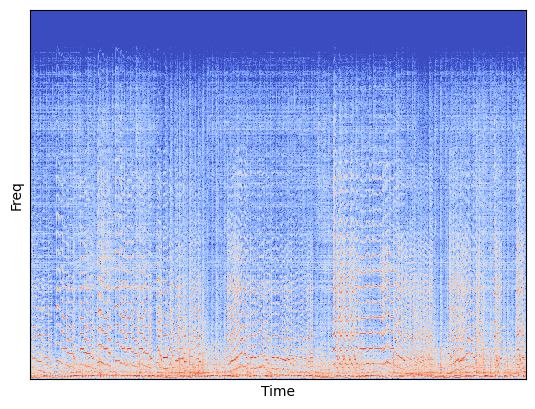

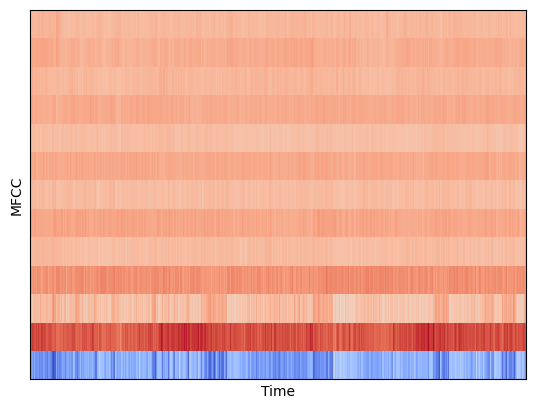

In [65]:
file = r'C:\Users\lenovo\AiTg2\Data\genres_original\jazz\jazz.00031.wav'
print(file)


# waveform
signal, sr = librosa.load(file, sr=22050)
dis.waveshow(signal, sr=sr)
plt.xlabel("Time")
plt.ylabel("Amp")
plt.show()


# fft -> spectrum
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_freq = frequency[: int(len(frequency) / 2)]
left_mag = magnitude[: int(len(magnitude) / 2)]

plt.plot(left_freq, left_mag, color="b")
plt.xlabel("freq")
plt.ylabel("mag")
plt.show()


# sfft >Freq
n_fft = 2048  # window when considering performing a single fft
hop_length = 512  # amount shifting after each transform

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.show()


# mfcc
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.show()


In [68]:
#กำหนดตำแหน่งที่อยู่ของไฟล์เสียงดนตรีในตัวแปร MUSIC
import os

MUSIC = "C:\\Users\\lenovo\\Aitg2\\Data\\genres_original"
music_dataset = []  #สร้าง music_dataset เพื่อเก็บเส้นทางของไฟล์เสียงดนตรีแต่ละไฟล์
genre_target = []  #สร้าง genre_target เพื่อเก็บแนวเพลงของแต่ละไฟล์

for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)

        # ตรวจสอบว่า filename ไม่เท่ากับ jazz.wav (หรือไฟล์ที่คุณไม่ต้องการ)
        if filename != 'C:\\Users\\lenovo\\Aitg2\\Data\\genres_original\\jazz\\jazz.00054.wav':
            music_dataset.append(filename)

            # แยกชื่อแนวเพลงจากเส้นทางไฟล์
            genre = os.path.basename(os.path.dirname(filename))
            genre_target.append(genre)





ผลลัพธ์ของโค้ดนี้คือ music_dataset จะมีรายการของเส้นทางไฟล์เสียงแต่ละไฟล์ในโฟลเดอร์ MUSIC และ genre_target จะมีข้อมูล Genres ของแต่ละไฟล์เสียงที่ถูกจัดเก็บลงใน list นี้ โดยเนื่องจากผมได้ใช้ .split("/") เพื่อแยกชื่อโฟลเดอร์ ดังนั้น Genres จะถูกแยกออกจากเส้นทางไฟล์และนำมาใส่ใน list genre_target ในตำแหน่งที่มีค่า 5 ซึ่งอาจเป็นชื่อของแนวเพลงที่ต้องการได้ตามโค้ด

In [ ]:
print("genres in dataset: ", set(genre_target))

genres in dataset:  {'hiphop', 'reggae', 'disco', 'country', 'blues', 'classical', 'metal', 'rock', 'jazz', 'pop'}


In [78]:
#โหลดเพื่อฟัง.wav
audio_path = music_dataset[500]#เลือกลำดับเพลงในนี้

x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)

In [79]:
# Visualizing Audio File as a waveform
plt.figure(figsize=(16, 5))
# librosa.display.waveplot(x, sr=sr)

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

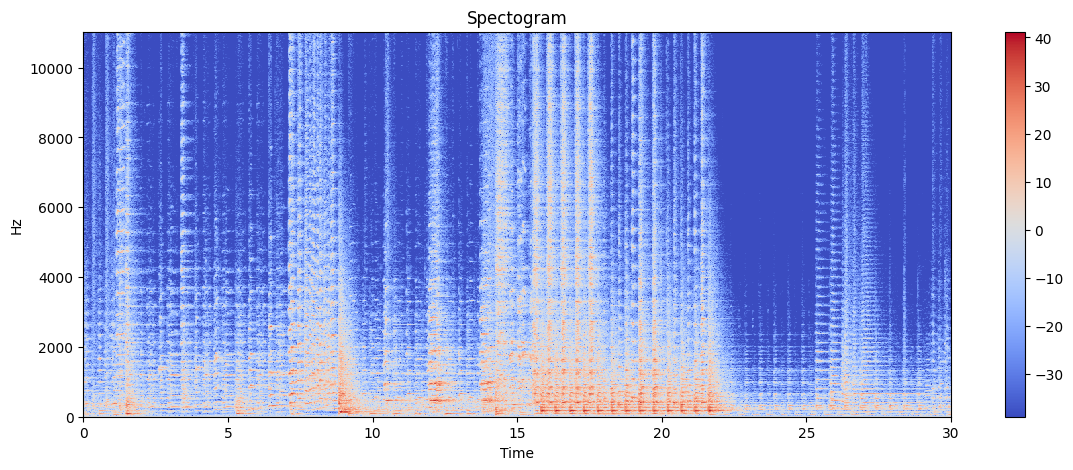

In [80]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

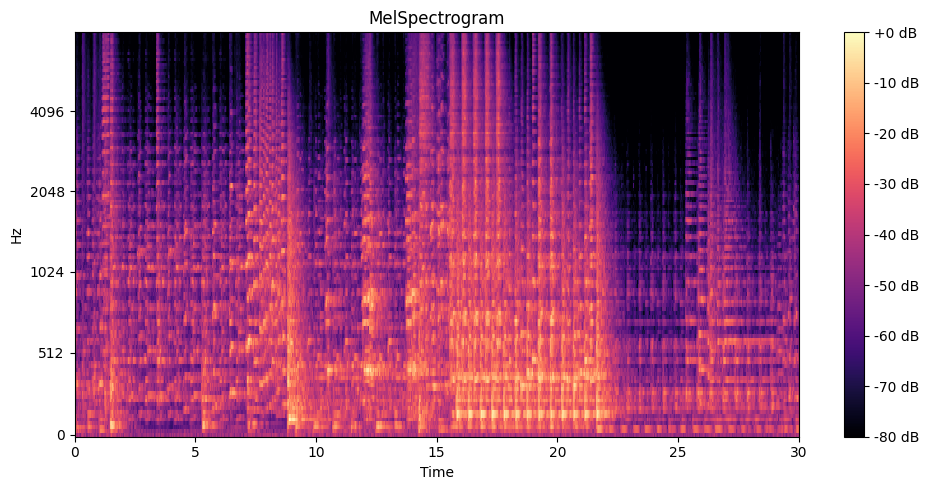

In [81]:
file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()

In [83]:

DATASET_PATH = 'C:\\Users\\lenovo\\Aitg2\\Data\\genres_original'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }
#กำหนดพารามิเตอร์ต่าง ๆ ที่เกี่ยวข้องกับการสร้าง MFCC เช่น SAMPLE_RATE, TRACK_DURATION, และ SAMPLES_PER_TRACK
    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                if file_path != 'C:\\Users\\lenovo\\Aitg2\\Data\\genres_original\\jazz\\jazz.00054.wav':
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=15)#ใช้ฟังก์ชัน save_mfcc เพื่อดึงคุณลักษณะ MFCC จากไฟล์เสียงดนตรีและบันทึกข้อมูลลงใน JSON ไฟล์ เพื่อนำมาใช้ในการเทรนโมเดล
print("process finished")


Processing: C:\Users\lenovo\Aitg2\Data\genres_original\blues

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\classical

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\country

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\disco

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\hiphop

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\jazz

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\metal

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\pop

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\reggae

Processing: C:\Users\lenovo\Aitg2\Data\genres_original\rock
process finished


In [85]:
# import os

# def remove_folder_contents(folder):
#     for the_file in os.listdir(folder):
#         file_path = os.path.join(folder, the_file)
#         try:
#             if os.path.isfile(file_path):
#                 os.unlink(file_path)
#             elif os.path.isdir(file_path):
#                 remove_folder_contents(file_path)
#                 os.rmdir(file_path)
#         except Exception as e:
#             print(e)

# folder_path = '/kaggle/working'
# # folder_path = '/kaggle/working/callbacks'
# remove_folder_contents(folder_path)

In [92]:
DATA_PATH = "./data_10.json"

def load_data(data_path): #ฟังก์ชัน load_data เพื่อโหลดข้อมูล MFCC จาก JSON ไฟล์ที่สร้างไว้และคืนค่าข้อมูลที่โหลดในรูปแบบของ Numpy arrays (X, y) และรายชื่อแนวเพลง (z)
 
    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history): #แสดงค่าเป็นกราฟในแต่ละครั้งที่เทรนเพื่อหาประมวลความถูกต้อง
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size): #ใช้ prepare_datasets เพื่อแบ่งข้อมูลเป็นชุดการฝึก (training), ชุดการตรวจสอบ (validation), และชุดทดสอบ (test)
    X, y, z = load_data(DATA_PATH)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True,random_state =42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=1, shuffle = True, random_state = 42)

    #ข้อมูลถูกแปลงให้มีขนาดเหมาะสมสำหรับการนำเข้าโมเดล CNN โดยเพิ่มมิติในชุดข้อมูลด้วย np.newaxis
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z

#ใช้ build_model เพื่อสร้างโมเดล CNN ที่ประกอบด้วยชั้น Convolutional, BatchNormalization, MaxPooling, Flatten, และ Dense
def build_model(input_shape):
    model = Sequential()
#     1st conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape, kernel_initializer = 'he_normal'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dropout(0.5))
    # output layer
    model.add(keras.layers.Dense(5, activation='softmax')) #ชั้นสุดท้ายมี 10 หน่วยตามชนิดของเพลงและฟังก์ชัน activation เป็น softmax เพื่อใช้ในการจำแนกแนวเพลง
    return model

    #ใช้ predict เพื่อทำนายแนวเพลงของตัวอย่าง
def predict(model, X, y):
    
    X = X[np.newaxis, ...]
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    target = z[y]
    predicted = z[predicted_index]

    print("Target: {}, Predicted label: {}".format(target, predicted))

ิอ้างอิงตามนี้ https://guopai.github.io/ml-blog19.html โดยนี่คือหน้าที่ของแต่ละเลเยอร์ ในแต่ละเลเยอร์ประกอบด้วย Conv2D MaxPooling2D BatchNormalization ถึงเลเยอร์ที่สาม ในส่วนของเลเยอร์ที่สามจะใช้ Flatten Dense และ Dropout แล้วจึงเอาท์พุทเป็น Dense ตามชนิดของชื่อเพลงออกมาฮะ

In [90]:
# os.mkdir('callbacks')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 86, 12, 32)        160       
                                                                 
 max_pooling2d (MaxPooling2  (None, 43, 6, 32)         0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 43, 6, 32)         128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 5, 32)         4128      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 21, 3, 32)         0         
 g2D)                                                            
                                                        

INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 2.3786 - accuracy: 0.2459 - val_loss: 3.2614 - val_accuracy: 0.1749 - 11s/epoch - 420ms/step
Epoch 2/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 1.7600 - accuracy: 0.3520 - val_loss: 3.5910 - val_accuracy: 0.1255 - 9s/epoch - 320ms/step
Epoch 3/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 1.5850 - accuracy: 0.4209 - val_loss: 2.8883 - val_accuracy: 0.1969 - 9s/epoch - 315ms/step
Epoch 4/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 1.4926 - accuracy: 0.4634 - val_loss: 2.8048 - val_accuracy: 0.2103 - 9s/epoch - 320ms/step
Epoch 5/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 1.4036 - accuracy: 0.4879 - val_loss: 2.1770 - val_accuracy: 0.2463 - 9s/epoch - 321ms/step
Epoch 6/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 1.3464 - accuracy: 0.5119 - val_loss: 1.5178 - val_accuracy: 0.4232 - 9s/epoch - 320ms/step
Epoch 7/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 1.2770 - accuracy: 0.5487 - val_loss: 1.5713 - val_accuracy: 0.4219 - 8s/epoch - 304ms/step
Epoch 8/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 1.2232 - accuracy: 0.5639 - val_loss: 1.2650 - val_accuracy: 0.5240 - 9s/epoch - 331ms/step
Epoch 9/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 1.1763 - accuracy: 0.5876 - val_loss: 1.1978 - val_accuracy: 0.5487 - 8s/epoch - 314ms/step
Epoch 10/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 1.1274 - accuracy: 0.6073 - val_loss: 1.2598 - val_accuracy: 0.5300 - 8s/epoch - 311ms/step
Epoch 11/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 1.0775 - accuracy: 0.6280 - val_loss: 1.0426 - val_accuracy: 0.6148 - 8s/epoch - 312ms/step
Epoch 12/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 1.0389 - accuracy: 0.6389 - val_loss: 1.0370 - val_accuracy: 0.6242 - 8s/epoch - 308ms/step
Epoch 13/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.9976 - accuracy: 0.6575 - val_loss: 0.9308 - val_accuracy: 0.6636 - 8s/epoch - 305ms/step
Epoch 14/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.9668 - accuracy: 0.6703 - val_loss: 0.9200 - val_accuracy: 0.6729 - 8s/epoch - 305ms/step
Epoch 15/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.9555 - accuracy: 0.6726 - val_loss: 0.9410 - val_accuracy: 0.6689 - 8s/epoch - 303ms/step
Epoch 16/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.9079 - accuracy: 0.6873 - val_loss: 0.8946 - val_accuracy: 0.6969 - 8s/epoch - 310ms/step
Epoch 17/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.8827 - accuracy: 0.6993 - val_loss: 0.9625 - val_accuracy: 0.6929 - 8s/epoch - 302ms/step
Epoch 18/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.8696 - accuracy: 0.7013 - val_loss: 0.8401 - val_accuracy: 0.7049 - 8s/epoch - 304ms/step
Epoch 19/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.8313 - accuracy: 0.7146 - val_loss: 0.8577 - val_accuracy: 0.6923 - 8s/epoch - 311ms/step
Epoch 20/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.8030 - accuracy: 0.7232 - val_loss: 0.7896 - val_accuracy: 0.7410 - 8s/epoch - 307ms/step
Epoch 21/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.7840 - accuracy: 0.7361 - val_loss: 1.1656 - val_accuracy: 0.6462 - 9s/epoch - 331ms/step
Epoch 22/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.7625 - accuracy: 0.7399 - val_loss: 0.8063 - val_accuracy: 0.7290 - 9s/epoch - 325ms/step
Epoch 23/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.7489 - accuracy: 0.7434 - val_loss: 0.8804 - val_accuracy: 0.7116 - 9s/epoch - 320ms/step
Epoch 24/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.7257 - accuracy: 0.7552 - val_loss: 0.8668 - val_accuracy: 0.7109 - 8s/epoch - 302ms/step
Epoch 25/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.7249 - accuracy: 0.7544 - val_loss: 0.7397 - val_accuracy: 0.7577 - 8s/epoch - 295ms/step
Epoch 26/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6890 - accuracy: 0.7688 - val_loss: 0.7682 - val_accuracy: 0.7470 - 8s/epoch - 296ms/step
Epoch 27/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6916 - accuracy: 0.7695 - val_loss: 0.8518 - val_accuracy: 0.7236 - 8s/epoch - 304ms/step
Epoch 28/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6780 - accuracy: 0.7725 - val_loss: 0.7158 - val_accuracy: 0.7637 - 8s/epoch - 294ms/step
Epoch 29/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6438 - accuracy: 0.7859 - val_loss: 0.7083 - val_accuracy: 0.7697 - 8s/epoch - 297ms/step
Epoch 30/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6312 - accuracy: 0.7820 - val_loss: 0.8924 - val_accuracy: 0.7170 - 8s/epoch - 302ms/step
Epoch 31/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6217 - accuracy: 0.7910 - val_loss: 0.9430 - val_accuracy: 0.7196 - 8s/epoch - 295ms/step
Epoch 32/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6132 - accuracy: 0.7922 - val_loss: 0.7727 - val_accuracy: 0.7450 - 8s/epoch - 295ms/step
Epoch 33/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.6066 - accuracy: 0.7922 - val_loss: 0.8318 - val_accuracy: 0.7356 - 8s/epoch - 294ms/step
Epoch 34/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5763 - accuracy: 0.8080 - val_loss: 0.7302 - val_accuracy: 0.7517 - 8s/epoch - 301ms/step
Epoch 35/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5666 - accuracy: 0.8103 - val_loss: 0.7118 - val_accuracy: 0.7664 - 8s/epoch - 292ms/step
Epoch 36/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5798 - accuracy: 0.8040 - val_loss: 0.7877 - val_accuracy: 0.7397 - 8s/epoch - 295ms/step
Epoch 37/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5493 - accuracy: 0.8163 - val_loss: 0.7614 - val_accuracy: 0.7717 - 8s/epoch - 290ms/step
Epoch 38/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5323 - accuracy: 0.8223 - val_loss: 0.7483 - val_accuracy: 0.7457 - 8s/epoch - 301ms/step
Epoch 39/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5220 - accuracy: 0.8267 - val_loss: 0.8478 - val_accuracy: 0.7410 - 8s/epoch - 293ms/step
Epoch 40/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5251 - accuracy: 0.8239 - val_loss: 0.7338 - val_accuracy: 0.7870 - 8s/epoch - 294ms/step
Epoch 41/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5240 - accuracy: 0.8244 - val_loss: 0.8605 - val_accuracy: 0.7603 - 8s/epoch - 304ms/step
Epoch 42/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.5130 - accuracy: 0.8278 - val_loss: 0.8577 - val_accuracy: 0.7437 - 8s/epoch - 289ms/step
Epoch 43/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4967 - accuracy: 0.8348 - val_loss: 0.7450 - val_accuracy: 0.7697 - 8s/epoch - 287ms/step
Epoch 44/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4858 - accuracy: 0.8370 - val_loss: 0.7889 - val_accuracy: 0.7744 - 8s/epoch - 289ms/step
Epoch 45/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4588 - accuracy: 0.8457 - val_loss: 0.8139 - val_accuracy: 0.7630 - 8s/epoch - 304ms/step
Epoch 46/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4816 - accuracy: 0.8401 - val_loss: 1.0761 - val_accuracy: 0.6996 - 8s/epoch - 294ms/step
Epoch 47/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4656 - accuracy: 0.8430 - val_loss: 0.7613 - val_accuracy: 0.7704 - 8s/epoch - 292ms/step
Epoch 48/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4546 - accuracy: 0.8455 - val_loss: 0.7765 - val_accuracy: 0.7744 - 8s/epoch - 293ms/step
Epoch 49/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4453 - accuracy: 0.8546 - val_loss: 0.7573 - val_accuracy: 0.7870 - 8s/epoch - 309ms/step
Epoch 50/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4251 - accuracy: 0.8584 - val_loss: 0.7942 - val_accuracy: 0.7770 - 8s/epoch - 294ms/step
Epoch 51/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4425 - accuracy: 0.8534 - val_loss: 0.8600 - val_accuracy: 0.7630 - 8s/epoch - 294ms/step
Epoch 52/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4426 - accuracy: 0.8518 - val_loss: 0.7351 - val_accuracy: 0.7757 - 8s/epoch - 294ms/step
Epoch 53/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4207 - accuracy: 0.8629 - val_loss: 0.8235 - val_accuracy: 0.7503 - 8s/epoch - 302ms/step
Epoch 54/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4054 - accuracy: 0.8615 - val_loss: 0.7971 - val_accuracy: 0.7777 - 8s/epoch - 297ms/step
Epoch 55/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4055 - accuracy: 0.8635 - val_loss: 0.7554 - val_accuracy: 0.7697 - 8s/epoch - 293ms/step
Epoch 56/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4097 - accuracy: 0.8644 - val_loss: 0.7897 - val_accuracy: 0.7664 - 8s/epoch - 292ms/step
Epoch 57/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3861 - accuracy: 0.8730 - val_loss: 0.8974 - val_accuracy: 0.7563 - 8s/epoch - 302ms/step
Epoch 58/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3916 - accuracy: 0.8744 - val_loss: 0.8369 - val_accuracy: 0.7817 - 8s/epoch - 294ms/step
Epoch 59/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.4115 - accuracy: 0.8664 - val_loss: 0.7321 - val_accuracy: 0.7830 - 8s/epoch - 292ms/step
Epoch 60/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3799 - accuracy: 0.8761 - val_loss: 1.2572 - val_accuracy: 0.7023 - 8s/epoch - 291ms/step
Epoch 61/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3894 - accuracy: 0.8733 - val_loss: 0.8555 - val_accuracy: 0.7817 - 8s/epoch - 300ms/step
Epoch 62/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3748 - accuracy: 0.8775 - val_loss: 0.7436 - val_accuracy: 0.7957 - 8s/epoch - 297ms/step
Epoch 63/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3695 - accuracy: 0.8765 - val_loss: 0.9086 - val_accuracy: 0.7837 - 8s/epoch - 295ms/step
Epoch 64/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3542 - accuracy: 0.8823 - val_loss: 0.8855 - val_accuracy: 0.7784 - 8s/epoch - 307ms/step
Epoch 65/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3490 - accuracy: 0.8839 - val_loss: 0.7828 - val_accuracy: 0.7804 - 8s/epoch - 293ms/step
Epoch 66/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3622 - accuracy: 0.8790 - val_loss: 0.8300 - val_accuracy: 0.7650 - 8s/epoch - 293ms/step
Epoch 67/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3506 - accuracy: 0.8830 - val_loss: 0.9189 - val_accuracy: 0.7777 - 8s/epoch - 294ms/step
Epoch 68/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3589 - accuracy: 0.8813 - val_loss: 1.0637 - val_accuracy: 0.7283 - 8s/epoch - 303ms/step
Epoch 69/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3571 - accuracy: 0.8825 - val_loss: 0.8024 - val_accuracy: 0.7830 - 8s/epoch - 293ms/step
Epoch 70/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3390 - accuracy: 0.8874 - val_loss: 1.1172 - val_accuracy: 0.7450 - 8s/epoch - 294ms/step
Epoch 71/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3293 - accuracy: 0.8907 - val_loss: 0.9993 - val_accuracy: 0.7510 - 8s/epoch - 293ms/step
Epoch 72/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3258 - accuracy: 0.8891 - val_loss: 0.8967 - val_accuracy: 0.7664 - 8s/epoch - 308ms/step
Epoch 73/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3356 - accuracy: 0.8888 - val_loss: 0.8491 - val_accuracy: 0.7597 - 8s/epoch - 297ms/step
Epoch 74/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3173 - accuracy: 0.8944 - val_loss: 0.8243 - val_accuracy: 0.7777 - 8s/epoch - 294ms/step
Epoch 75/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3190 - accuracy: 0.8946 - val_loss: 0.9359 - val_accuracy: 0.7804 - 8s/epoch - 304ms/step
Epoch 76/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3193 - accuracy: 0.8937 - val_loss: 0.8921 - val_accuracy: 0.7664 - 8s/epoch - 295ms/step
Epoch 77/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3298 - accuracy: 0.8899 - val_loss: 0.8774 - val_accuracy: 0.7690 - 8s/epoch - 294ms/step
Epoch 78/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3146 - accuracy: 0.8966 - val_loss: 0.7817 - val_accuracy: 0.7770 - 8s/epoch - 294ms/step
Epoch 79/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3044 - accuracy: 0.8989 - val_loss: 0.9834 - val_accuracy: 0.7697 - 8s/epoch - 305ms/step
Epoch 80/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.3097 - accuracy: 0.8981 - val_loss: 0.9400 - val_accuracy: 0.7850 - 9s/epoch - 336ms/step
Epoch 81/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3136 - accuracy: 0.8926 - val_loss: 0.9808 - val_accuracy: 0.7550 - 8s/epoch - 292ms/step
Epoch 82/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.3019 - accuracy: 0.8989 - val_loss: 0.9529 - val_accuracy: 0.7503 - 8s/epoch - 289ms/step
Epoch 83/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.3034 - accuracy: 0.8995 - val_loss: 0.8772 - val_accuracy: 0.7904 - 9s/epoch - 319ms/step
Epoch 84/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2821 - accuracy: 0.9061 - val_loss: 1.0094 - val_accuracy: 0.7824 - 8s/epoch - 308ms/step
Epoch 85/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2886 - accuracy: 0.9086 - val_loss: 0.8843 - val_accuracy: 0.7750 - 8s/epoch - 310ms/step
Epoch 86/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2956 - accuracy: 0.9034 - val_loss: 0.8482 - val_accuracy: 0.7870 - 8s/epoch - 308ms/step
Epoch 87/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.3005 - accuracy: 0.9021 - val_loss: 0.8812 - val_accuracy: 0.7724 - 9s/epoch - 336ms/step
Epoch 88/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2904 - accuracy: 0.9039 - val_loss: 0.9162 - val_accuracy: 0.7777 - 8s/epoch - 300ms/step
Epoch 89/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2893 - accuracy: 0.9064 - val_loss: 0.9948 - val_accuracy: 0.7730 - 8s/epoch - 297ms/step
Epoch 90/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2837 - accuracy: 0.9098 - val_loss: 0.9164 - val_accuracy: 0.7830 - 8s/epoch - 297ms/step
Epoch 91/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.3155 - accuracy: 0.8985 - val_loss: 0.8651 - val_accuracy: 0.7790 - 9s/epoch - 317ms/step
Epoch 92/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2932 - accuracy: 0.9026 - val_loss: 0.8795 - val_accuracy: 0.7864 - 8s/epoch - 303ms/step
Epoch 93/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2759 - accuracy: 0.9064 - val_loss: 0.8996 - val_accuracy: 0.7944 - 8s/epoch - 295ms/step
Epoch 94/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2759 - accuracy: 0.9087 - val_loss: 1.0322 - val_accuracy: 0.7737 - 9s/epoch - 325ms/step
Epoch 95/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2642 - accuracy: 0.9118 - val_loss: 1.2906 - val_accuracy: 0.7730 - 8s/epoch - 304ms/step
Epoch 96/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2653 - accuracy: 0.9129 - val_loss: 1.1828 - val_accuracy: 0.7697 - 8s/epoch - 296ms/step
Epoch 97/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2772 - accuracy: 0.9090 - val_loss: 0.9754 - val_accuracy: 0.7877 - 8s/epoch - 292ms/step
Epoch 98/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2745 - accuracy: 0.9084 - val_loss: 0.9235 - val_accuracy: 0.7991 - 8s/epoch - 301ms/step
Epoch 99/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2521 - accuracy: 0.9144 - val_loss: 0.8809 - val_accuracy: 0.7971 - 8s/epoch - 300ms/step
Epoch 100/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2641 - accuracy: 0.9164 - val_loss: 1.1214 - val_accuracy: 0.7784 - 8s/epoch - 295ms/step
Epoch 101/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2595 - accuracy: 0.9133 - val_loss: 0.9345 - val_accuracy: 0.7817 - 8s/epoch - 296ms/step
Epoch 102/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2455 - accuracy: 0.9205 - val_loss: 1.1060 - val_accuracy: 0.7697 - 8s/epoch - 309ms/step
Epoch 103/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2484 - accuracy: 0.9220 - val_loss: 0.9354 - val_accuracy: 0.7891 - 8s/epoch - 292ms/step
Epoch 104/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2370 - accuracy: 0.9233 - val_loss: 1.0009 - val_accuracy: 0.7837 - 8s/epoch - 295ms/step
Epoch 105/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2410 - accuracy: 0.9193 - val_loss: 0.9983 - val_accuracy: 0.7884 - 8s/epoch - 294ms/step
Epoch 106/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2457 - accuracy: 0.9213 - val_loss: 0.8991 - val_accuracy: 0.7884 - 8s/epoch - 303ms/step
Epoch 107/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2388 - accuracy: 0.9215 - val_loss: 0.9877 - val_accuracy: 0.7837 - 8s/epoch - 297ms/step
Epoch 108/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2389 - accuracy: 0.9228 - val_loss: 1.1066 - val_accuracy: 0.7657 - 8s/epoch - 293ms/step
Epoch 109/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2433 - accuracy: 0.9195 - val_loss: 1.0465 - val_accuracy: 0.7777 - 8s/epoch - 307ms/step
Epoch 110/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2549 - accuracy: 0.9150 - val_loss: 1.2146 - val_accuracy: 0.7770 - 8s/epoch - 296ms/step
Epoch 111/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2618 - accuracy: 0.9138 - val_loss: 1.1110 - val_accuracy: 0.7664 - 8s/epoch - 295ms/step
Epoch 112/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2651 - accuracy: 0.9133 - val_loss: 1.1068 - val_accuracy: 0.7784 - 8s/epoch - 296ms/step
Epoch 113/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2543 - accuracy: 0.9185 - val_loss: 1.0321 - val_accuracy: 0.7877 - 8s/epoch - 304ms/step
Epoch 114/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2347 - accuracy: 0.9211 - val_loss: 0.9860 - val_accuracy: 0.7830 - 8s/epoch - 306ms/step
Epoch 115/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2288 - accuracy: 0.9262 - val_loss: 1.2532 - val_accuracy: 0.7704 - 8s/epoch - 296ms/step
Epoch 116/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2430 - accuracy: 0.9205 - val_loss: 1.0311 - val_accuracy: 0.7944 - 8s/epoch - 304ms/step
Epoch 117/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2412 - accuracy: 0.9208 - val_loss: 1.1450 - val_accuracy: 0.7617 - 8s/epoch - 305ms/step
Epoch 118/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2358 - accuracy: 0.9219 - val_loss: 1.0213 - val_accuracy: 0.7870 - 8s/epoch - 294ms/step
Epoch 119/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2331 - accuracy: 0.9250 - val_loss: 1.0631 - val_accuracy: 0.7877 - 8s/epoch - 295ms/step
Epoch 120/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2236 - accuracy: 0.9267 - val_loss: 0.9651 - val_accuracy: 0.7870 - 8s/epoch - 297ms/step
Epoch 121/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2224 - accuracy: 0.9286 - val_loss: 1.0209 - val_accuracy: 0.7810 - 8s/epoch - 305ms/step
Epoch 122/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2329 - accuracy: 0.9243 - val_loss: 1.1477 - val_accuracy: 0.7784 - 8s/epoch - 297ms/step
Epoch 123/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2445 - accuracy: 0.9188 - val_loss: 0.9686 - val_accuracy: 0.7677 - 8s/epoch - 312ms/step
Epoch 124/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2215 - accuracy: 0.9267 - val_loss: 0.9883 - val_accuracy: 0.7944 - 9s/epoch - 315ms/step
Epoch 125/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2210 - accuracy: 0.9281 - val_loss: 1.2624 - val_accuracy: 0.7583 - 8s/epoch - 306ms/step
Epoch 126/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2286 - accuracy: 0.9288 - val_loss: 1.0585 - val_accuracy: 0.7777 - 8s/epoch - 294ms/step
Epoch 127/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2109 - accuracy: 0.9314 - val_loss: 1.1520 - val_accuracy: 0.7770 - 8s/epoch - 298ms/step
Epoch 128/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2056 - accuracy: 0.9331 - val_loss: 1.1538 - val_accuracy: 0.7790 - 8s/epoch - 297ms/step
Epoch 129/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2547 - accuracy: 0.9193 - val_loss: 1.1738 - val_accuracy: 0.7784 - 8s/epoch - 307ms/step
Epoch 130/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2198 - accuracy: 0.9274 - val_loss: 1.0749 - val_accuracy: 0.7891 - 9s/epoch - 335ms/step
Epoch 131/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2422 - accuracy: 0.9262 - val_loss: 1.0495 - val_accuracy: 0.7917 - 8s/epoch - 281ms/step
Epoch 132/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2274 - accuracy: 0.9255 - val_loss: 1.0210 - val_accuracy: 0.7924 - 8s/epoch - 293ms/step
Epoch 133/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2268 - accuracy: 0.9241 - val_loss: 1.2681 - val_accuracy: 0.7750 - 8s/epoch - 280ms/step
Epoch 134/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2065 - accuracy: 0.9348 - val_loss: 1.1374 - val_accuracy: 0.7824 - 8s/epoch - 280ms/step
Epoch 135/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2203 - accuracy: 0.9285 - val_loss: 0.9969 - val_accuracy: 0.7884 - 9s/epoch - 331ms/step
Epoch 136/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2255 - accuracy: 0.9244 - val_loss: 0.9726 - val_accuracy: 0.7911 - 9s/epoch - 326ms/step
Epoch 137/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2221 - accuracy: 0.9293 - val_loss: 1.4174 - val_accuracy: 0.7597 - 8s/epoch - 283ms/step
Epoch 138/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2173 - accuracy: 0.9320 - val_loss: 1.1544 - val_accuracy: 0.7644 - 8s/epoch - 311ms/step
Epoch 139/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.2357 - accuracy: 0.9224 - val_loss: 1.0795 - val_accuracy: 0.7870 - 10s/epoch - 368ms/step
Epoch 140/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2131 - accuracy: 0.9326 - val_loss: 1.0177 - val_accuracy: 0.7730 - 8s/epoch - 302ms/step
Epoch 141/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2092 - accuracy: 0.9322 - val_loss: 1.2384 - val_accuracy: 0.7817 - 8s/epoch - 292ms/step
Epoch 142/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2314 - accuracy: 0.9261 - val_loss: 1.1617 - val_accuracy: 0.7610 - 8s/epoch - 284ms/step
Epoch 143/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2077 - accuracy: 0.9299 - val_loss: 1.0287 - val_accuracy: 0.7864 - 8s/epoch - 294ms/step
Epoch 144/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2082 - accuracy: 0.9342 - val_loss: 1.1526 - val_accuracy: 0.7730 - 8s/epoch - 293ms/step
Epoch 145/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 13s - loss: 0.2012 - accuracy: 0.9359 - val_loss: 1.1204 - val_accuracy: 0.7857 - 13s/epoch - 470ms/step
Epoch 146/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.2034 - accuracy: 0.9328 - val_loss: 1.1686 - val_accuracy: 0.7830 - 10s/epoch - 369ms/step
Epoch 147/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.1974 - accuracy: 0.9344 - val_loss: 1.0646 - val_accuracy: 0.7837 - 9s/epoch - 326ms/step
Epoch 148/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2050 - accuracy: 0.9341 - val_loss: 1.2497 - val_accuracy: 0.7717 - 8s/epoch - 292ms/step
Epoch 149/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2048 - accuracy: 0.9339 - val_loss: 1.1273 - val_accuracy: 0.7684 - 8s/epoch - 298ms/step
Epoch 150/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2051 - accuracy: 0.9341 - val_loss: 1.2180 - val_accuracy: 0.7697 - 8s/epoch - 292ms/step
Epoch 151/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 8s - loss: 0.2057 - accuracy: 0.9340 - val_loss: 1.0752 - val_accuracy: 0.7877 - 8s/epoch - 300ms/step
Epoch 152/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.2044 - accuracy: 0.9331 - val_loss: 1.4632 - val_accuracy: 0.7537 - 10s/epoch - 359ms/step
Epoch 153/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.2103 - accuracy: 0.9331 - val_loss: 1.2496 - val_accuracy: 0.7804 - 11s/epoch - 407ms/step
Epoch 154/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2243 - accuracy: 0.9281 - val_loss: 1.0028 - val_accuracy: 0.7837 - 9s/epoch - 347ms/step
Epoch 155/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 9s - loss: 0.2231 - accuracy: 0.9280 - val_loss: 1.2380 - val_accuracy: 0.7537 - 9s/epoch - 348ms/step
Epoch 156/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 12s - loss: 0.2096 - accuracy: 0.9314 - val_loss: 1.3606 - val_accuracy: 0.7623 - 12s/epoch - 438ms/step
Epoch 157/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 12s - loss: 0.2110 - accuracy: 0.9334 - val_loss: 1.3413 - val_accuracy: 0.7824 - 12s/epoch - 429ms/step
Epoch 158/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 16s - loss: 0.1947 - accuracy: 0.9394 - val_loss: 1.1481 - val_accuracy: 0.7904 - 16s/epoch - 605ms/step
Epoch 159/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 12s - loss: 0.1968 - accuracy: 0.9369 - val_loss: 1.3007 - val_accuracy: 0.7690 - 12s/epoch - 443ms/step
Epoch 160/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 12s - loss: 0.2120 - accuracy: 0.9300 - val_loss: 1.2848 - val_accuracy: 0.7557 - 12s/epoch - 426ms/step
Epoch 161/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 14s - loss: 0.2054 - accuracy: 0.9345 - val_loss: 1.4100 - val_accuracy: 0.7650 - 14s/epoch - 510ms/step
Epoch 162/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.2049 - accuracy: 0.9322 - val_loss: 1.1056 - val_accuracy: 0.7904 - 11s/epoch - 405ms/step
Epoch 163/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.1978 - accuracy: 0.9366 - val_loss: 1.2178 - val_accuracy: 0.7704 - 10s/epoch - 385ms/step
Epoch 164/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.2145 - accuracy: 0.9328 - val_loss: 1.2551 - val_accuracy: 0.7697 - 10s/epoch - 376ms/step
Epoch 165/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.2418 - accuracy: 0.9213 - val_loss: 1.1576 - val_accuracy: 0.7737 - 10s/epoch - 370ms/step
Epoch 166/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.2086 - accuracy: 0.9337 - val_loss: 1.2209 - val_accuracy: 0.7750 - 11s/epoch - 405ms/step
Epoch 167/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.1846 - accuracy: 0.9407 - val_loss: 1.5043 - val_accuracy: 0.7537 - 10s/epoch - 380ms/step
Epoch 168/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.1997 - accuracy: 0.9374 - val_loss: 1.1677 - val_accuracy: 0.7884 - 11s/epoch - 391ms/step
Epoch 169/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.1998 - accuracy: 0.9345 - val_loss: 1.2324 - val_accuracy: 0.7730 - 11s/epoch - 424ms/step
Epoch 170/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.1941 - accuracy: 0.9367 - val_loss: 1.3291 - val_accuracy: 0.7677 - 11s/epoch - 413ms/step
Epoch 171/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 12s - loss: 0.1815 - accuracy: 0.9418 - val_loss: 1.1337 - val_accuracy: 0.7937 - 12s/epoch - 431ms/step
Epoch 172/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 10s - loss: 0.1804 - accuracy: 0.9408 - val_loss: 1.2586 - val_accuracy: 0.7917 - 10s/epoch - 374ms/step
Epoch 173/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 14s - loss: 0.1701 - accuracy: 0.9450 - val_loss: 1.1146 - val_accuracy: 0.7891 - 14s/epoch - 536ms/step
Epoch 174/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 13s - loss: 0.1796 - accuracy: 0.9420 - val_loss: 1.2047 - val_accuracy: 0.7577 - 13s/epoch - 464ms/step
Epoch 175/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 13s - loss: 0.1814 - accuracy: 0.9418 - val_loss: 1.2802 - val_accuracy: 0.7724 - 13s/epoch - 479ms/step
Epoch 176/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 11s - loss: 0.1797 - accuracy: 0.9410 - val_loss: 1.3360 - val_accuracy: 0.7670 - 11s/epoch - 421ms/step
Epoch 177/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 12s - loss: 0.2052 - accuracy: 0.9328 - val_loss: 1.1813 - val_accuracy: 0.7830 - 12s/epoch - 457ms/step
Epoch 178/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 13s - loss: 0.1781 - accuracy: 0.9413 - val_loss: 1.3672 - val_accuracy: 0.7797 - 13s/epoch - 478ms/step
Epoch 179/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 21s - loss: 0.1832 - accuracy: 0.9414 - val_loss: 1.1134 - val_accuracy: 0.7844 - 21s/epoch - 771ms/step
Epoch 180/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 20s - loss: 0.1893 - accuracy: 0.9398 - val_loss: 1.1293 - val_accuracy: 0.7704 - 20s/epoch - 724ms/step
Epoch 181/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 18s - loss: 0.1919 - accuracy: 0.9397 - val_loss: 1.2593 - val_accuracy: 0.7824 - 18s/epoch - 665ms/step
Epoch 182/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 19s - loss: 0.1783 - accuracy: 0.9425 - val_loss: 1.2367 - val_accuracy: 0.7790 - 19s/epoch - 710ms/step
Epoch 183/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 17s - loss: 0.1778 - accuracy: 0.9425 - val_loss: 1.4885 - val_accuracy: 0.7724 - 17s/epoch - 626ms/step
Epoch 184/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 20s - loss: 0.1952 - accuracy: 0.9372 - val_loss: 1.3572 - val_accuracy: 0.7710 - 20s/epoch - 722ms/step
Epoch 185/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 18s - loss: 0.1918 - accuracy: 0.9384 - val_loss: 1.2133 - val_accuracy: 0.7617 - 18s/epoch - 673ms/step
Epoch 186/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 16s - loss: 0.1845 - accuracy: 0.9415 - val_loss: 1.3532 - val_accuracy: 0.7657 - 16s/epoch - 579ms/step
Epoch 187/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1879 - accuracy: 0.9411 - val_loss: 1.2243 - val_accuracy: 0.7677 - 15s/epoch - 573ms/step
Epoch 188/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1738 - accuracy: 0.9434 - val_loss: 1.1752 - val_accuracy: 0.7951 - 15s/epoch - 542ms/step
Epoch 189/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 16s - loss: 0.1702 - accuracy: 0.9455 - val_loss: 1.5037 - val_accuracy: 0.7623 - 16s/epoch - 576ms/step
Epoch 190/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1751 - accuracy: 0.9446 - val_loss: 1.1122 - val_accuracy: 0.7911 - 15s/epoch - 568ms/step
Epoch 191/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1942 - accuracy: 0.9413 - val_loss: 1.2319 - val_accuracy: 0.7650 - 15s/epoch - 567ms/step
Epoch 192/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1788 - accuracy: 0.9421 - val_loss: 1.1496 - val_accuracy: 0.8077 - 15s/epoch - 557ms/step
Epoch 193/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1814 - accuracy: 0.9441 - val_loss: 1.1457 - val_accuracy: 0.7931 - 15s/epoch - 549ms/step
Epoch 194/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1869 - accuracy: 0.9406 - val_loss: 1.1858 - val_accuracy: 0.7690 - 15s/epoch - 559ms/step
Epoch 195/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1780 - accuracy: 0.9438 - val_loss: 1.3934 - val_accuracy: 0.7824 - 15s/epoch - 540ms/step
Epoch 196/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1571 - accuracy: 0.9483 - val_loss: 1.2785 - val_accuracy: 0.7850 - 15s/epoch - 567ms/step
Epoch 197/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 18s - loss: 0.1874 - accuracy: 0.9430 - val_loss: 1.3360 - val_accuracy: 0.7830 - 18s/epoch - 663ms/step
Epoch 198/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 16s - loss: 0.2009 - accuracy: 0.9368 - val_loss: 1.2134 - val_accuracy: 0.7797 - 16s/epoch - 600ms/step
Epoch 199/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1869 - accuracy: 0.9382 - val_loss: 1.0772 - val_accuracy: 0.7804 - 15s/epoch - 552ms/step
Epoch 200/200
INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


INFO:tensorflow:Assets written to: /kaggle/working\callbacks\assets


27/27 - 15s - loss: 0.1704 - accuracy: 0.9462 - val_loss: 1.3113 - val_accuracy: 0.7757 - 15s/epoch - 569ms/step


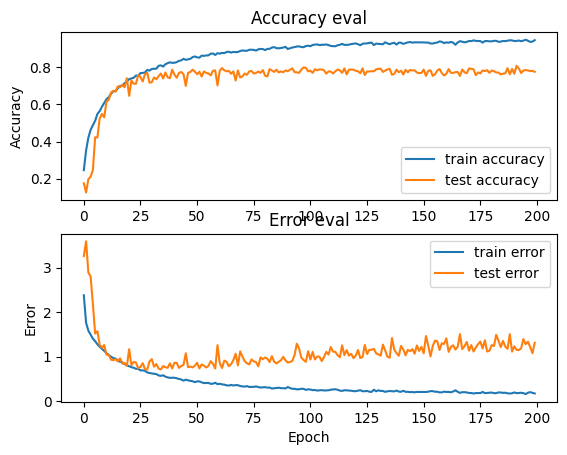

47/47 - 0s - loss: 1.3113 - accuracy: 0.7757 - 417ms/epoch - 9ms/step

Test accuracy: 0.7757009267807007


In [91]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.1, 0)

# สร้าง network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# เทรนโมเดล
optimiser = keras.optimizers.Adam(learning_rate=0.0025)#กำหนดการคอมไพล์โมเดลด้วย optimizer และ loss function
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_callbacks = [tf.keras.callbacks.ModelCheckpoint( #ใช้ tf.keras.callbacks.ModelCheckpoint เพื่อบันทึกโมเดลที่มีค่าความสูญเสียต่ำสุด
    filepath = "/kaggle/working/callbacks",
    monitor = "val_loss",
    mode = "min"
)]
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=512, epochs=500, verbose = 2, callbacks = my_callbacks)
# บันทึกประวัติการฝึกเพื่อพล็อตกราฟ
plot_history(history)

# แสดงความแม่นยำและความผิดพลาด
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)#ใช้ model.evaluate เพื่อประเมินประสิทธิภาพของโมเดลบนชุดทดสอบ
print('\nTest accuracy:', test_acc)

In [96]:
# บันทึกโมเดลหลังจากเทรนเสร็จสิ้น
model.save('my_model.keras')

In [93]:
# pick a sample to predict from the test set
X_to_predict = X_test[165]
y_to_predict = y_test[165]
# predict sample
print(predict(model, X_to_predict, y_to_predict))

1/1 [==============================] - 0s 243ms/step
Target: C:\Users\lenovo\Aitg2\Data\genres_original\jazz, Predicted label: ['C:\\Users\\lenovo\\Aitg2\\Data\\genres_original\\jazz']
None


In [94]:
model.evaluate(X_test, y_test)
#model.evaluate เพื่อประเมินประสิทธิภาพของโมเดลบนชุดทดสอบ

47/47 [==============================] - 0s 6ms/step - loss: 1.3113 - accuracy: 0.7757


[1.311286211013794, 0.7757009267807007]